# Evoked response to word onsets

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import zscore
from functools import partial

from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

In [2]:
df = pd.read_csv("../monkey/stimuli/monkey_util-whisperx_transcript.csv")
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
df.head()

word  start    end  score
0     Act  3.710  3.790  0.367
1    one,  3.990  4.190  0.688
2  monkey  4.651  4.931  0.866
3      in  4.951  5.011  0.780
4     the  5.051  5.111  0.998

In [3]:
events = np.zeros((len(df), 3))
events[:, 0] = df.start
events

array([[   3.71 ,    0.   ,    0.   ],
       [   3.99 ,    0.   ,    0.   ],
       [   4.651,    0.   ,    0.   ],
       ...,
       [1798.786,    0.   ,    0.   ],
       [1799.046,    0.   ,    0.   ],
       [1799.327,    0.   ,    0.   ]])

In [18]:
edf_path = BIDSPath(root="../monkey/derivatives/ecogprep", subject="02", datatype="ieeg", description="highgamma", extension=".fif")
edf_path = edf_path.match()[0]
raw = mne.io.read_raw_fif(edf_path, preload=True)
raw

Opening raw data file ../monkey/derivatives/ecogprep/sub-02/ieeg/sub-02_task-monkey_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Reading 0 ... 921599  =      0.000 ...  1799.998 secs...


<Raw | sub-02_task-monkey_desc-highgamma_ieeg.fif, 186 x 921600 (1800.0 s), ~1.28 GB, data loaded>

In [19]:
func = partial(zscore, axis=1)
raw = raw.apply_function(func, channel_wise=False)
raw

<Raw | sub-02_task-monkey_desc-highgamma_ieeg.fif, 186 x 921600 (1800.0 s), ~1.28 GB, data loaded>

In [23]:
epochs = mne.Epochs(
    raw,
    (events * raw.info['sfreq']).astype(int),
    tmin=-2.0,
    tmax=2.0,
    baseline=None,
    proj=None,
    event_id=None,
    preload=True,
    event_repeated="merge",
)

Not setting metadata
4774 matching events found
No baseline correction applied
Using data from preloaded Raw for 4774 events and 2049 original time points ...
6 bad epochs dropped


In [24]:
evoked = epochs.average()
evoked.data.shape

(186, 2049)

In [31]:
evoked.data.max(-1).argsort()[-5:]

array([ 36,   8, 182, 184, 183])

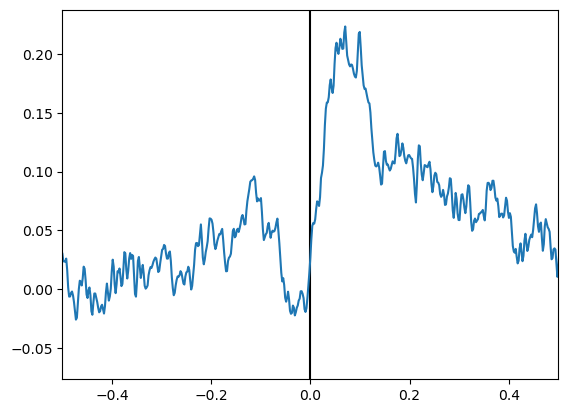

In [28]:
lags = np.arange(-2*512, 2*512+1)
lags_s = lags / 512

plt.axvline(0, c='k')
plt.plot(lags_s, evoked.data[183])
plt.xlim(-.5, .5)
plt.show()

In [29]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
coords.shape

(186, 3)

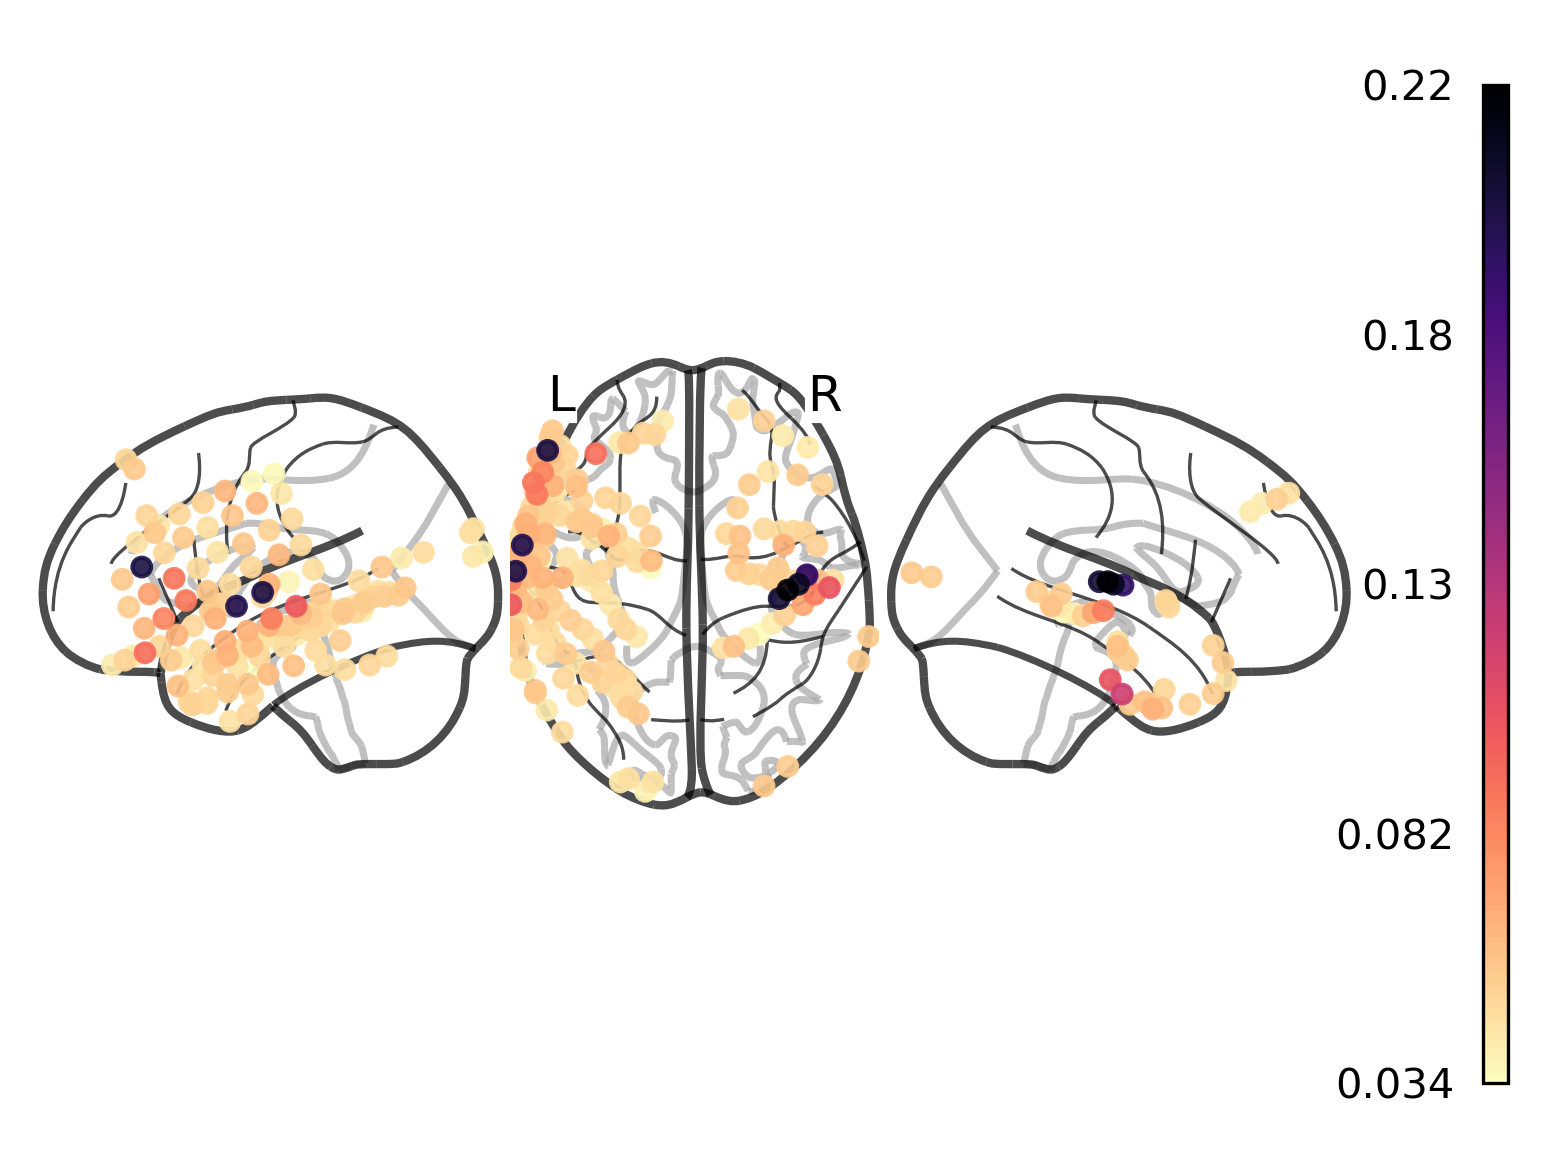

In [30]:
values = evoked.data.max(-1)

order = values.argsort()
fig, ax = plt.subplots(dpi=300)
plot_markers(values[order], coords[order],
                node_size=20, display_mode='lzr',
                node_cmap='magma_r', colorbar=True,
                alpha=0.9, #node_vmin=0,
                figure=fig, axes=ax)
fig.show()